# Gym Experience Classification using Support Vector Machines

This project explores how machine learning models can classify gym members as **Beginner** or **Experienced** using demographic, physiological, and workout-related features.


In [704]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

## 1. Data Loading and Initial Inspection

We begin by loading the dataset and inspecting its structure, data types, and basic statistics to ensure data quality.


In [705]:
gym_df = pd.read_csv('gym.csv')
print(gym_df.head().to_string())

   Age  Gender  Weight (kg)  Height (m)  Max_BPM  Avg_BPM  Resting_BPM  Session_Duration (hours)  Calories_Burned Workout_Type  Fat_Percentage  Water_Intake (liters)  Workout_Frequency (days/week)  Experience_Level    BMI
0   56    Male         88.3        1.71      180      157           60                      1.69           1313.0         Yoga            12.6                    3.5                              4                 3  30.20
1   46  Female         74.9        1.53      179      151           66                      1.30            883.0         HIIT            33.9                    2.1                              4                 2  32.00
2   32  Female         68.1        1.66      167      122           54                      1.11            677.0       Cardio            33.4                    2.3                              4                 2  24.71
3   25    Male         53.2        1.70      190      164           56                      0.59            532.

In [706]:
gym_df.shape

(973, 15)

In [662]:
print(gym_df.describe())
print(gym_df.info())
print(gym_df.isna().sum())
print(gym_df.duplicated().sum())

              Age  Weight (kg)  Height (m)     Max_BPM     Avg_BPM  \
count  973.000000   973.000000   973.00000  973.000000  973.000000   
mean    38.683453    73.854676     1.72258  179.883864  143.766701   
std     12.180928    21.207500     0.12772   11.525686   14.345101   
min     18.000000    40.000000     1.50000  160.000000  120.000000   
25%     28.000000    58.100000     1.62000  170.000000  131.000000   
50%     40.000000    70.000000     1.71000  180.000000  143.000000   
75%     49.000000    86.000000     1.80000  190.000000  156.000000   
max     59.000000   129.900000     2.00000  199.000000  169.000000   

       Resting_BPM  Session_Duration (hours)  Calories_Burned  Fat_Percentage  \
count   973.000000                973.000000       973.000000      973.000000   
mean     62.223022                  1.256423       905.422405       24.976773   
std       7.327060                  0.343033       272.641516        6.259419   
min      50.000000                  0.500000 


## 2. Exploratory Data Analysis (EDA)

In this section, we explore distributions of demographic and workout-related features, as well as correlations among numerical variables. This helps us understand patterns and relationships before modeling.


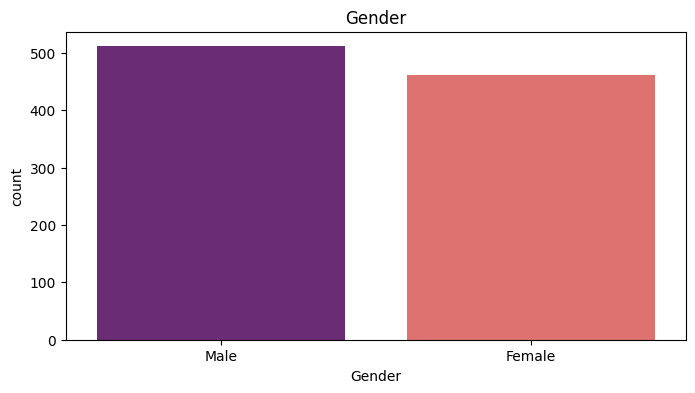

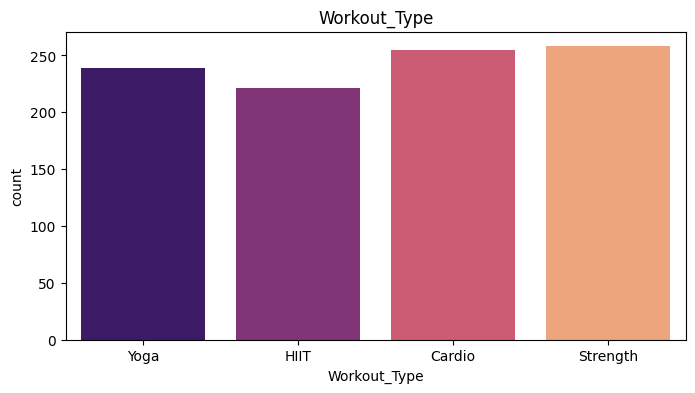

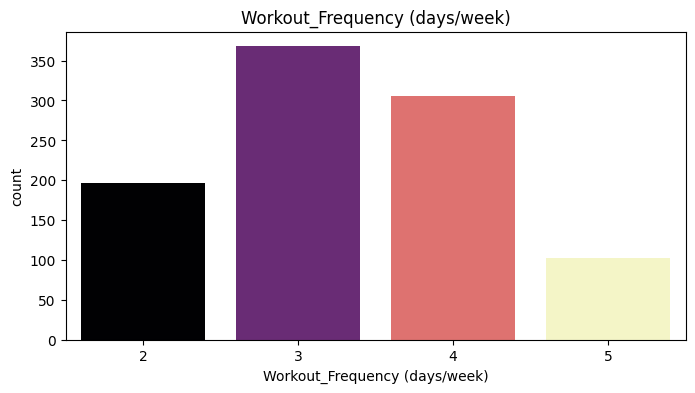

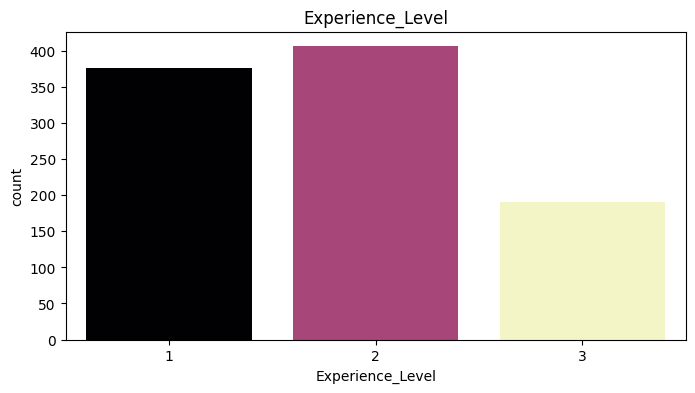

In [663]:
cols = ['Gender','Workout_Type','Workout_Frequency (days/week)','Experience_Level']
for col in cols:
    plt.figure(figsize=(8,4))
    sns.countplot(x=col, data = gym_df,palette = 'magma',hue=col,legend=False)
    plt.title(col)
plt.show()

In [664]:
cols = ['Weight (kg)','Height (m)']

<Axes: >

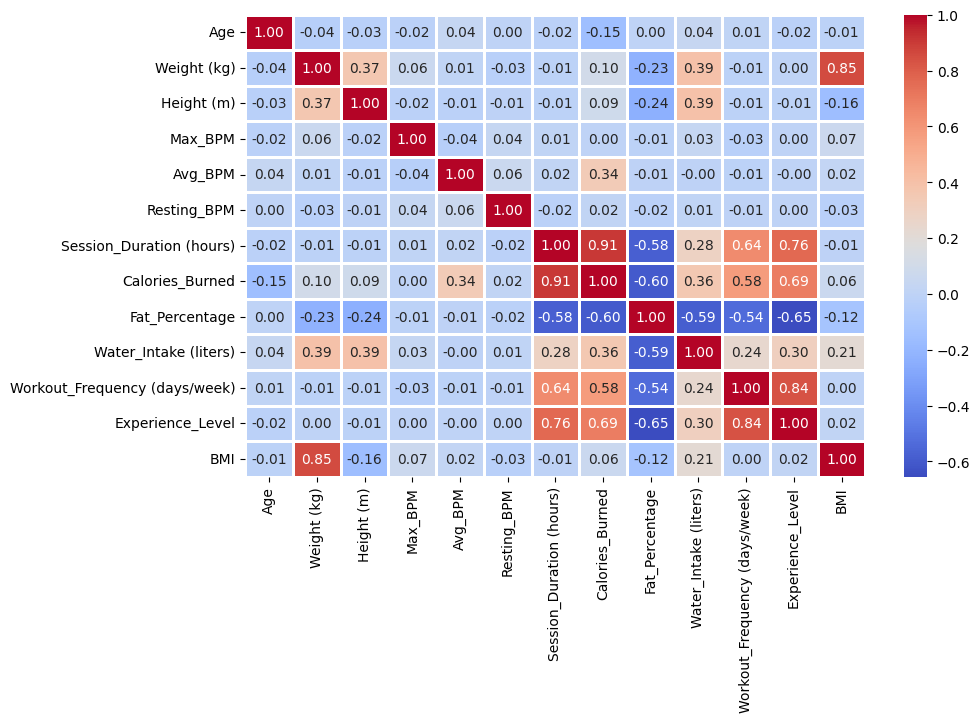

In [665]:
num_cols = gym_df.select_dtypes(include = 'number').corr()
plt.figure(figsize=(10,6))
sns.heatmap(num_cols,annot=True,cmap='coolwarm',linewidths=1,fmt='.2f')

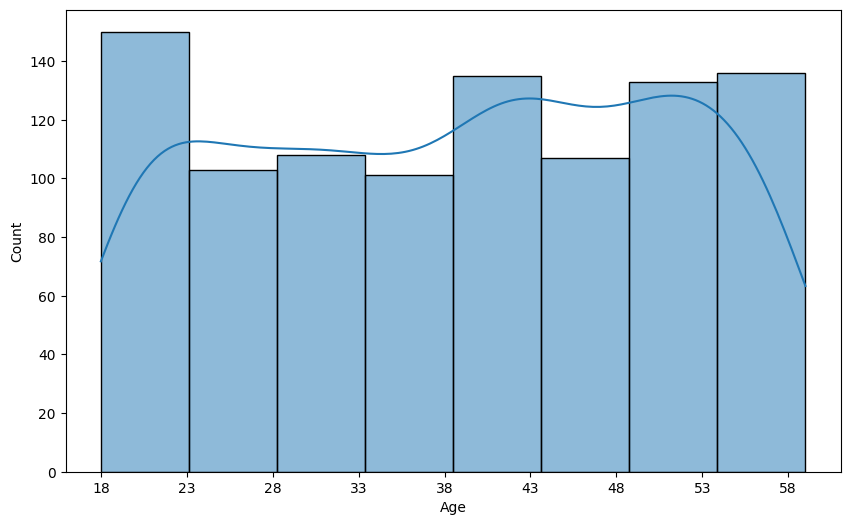

In [666]:
plt.figure(figsize=(10,6))
sns.histplot(data = gym_df, x = 'Age',binwidth = 5,kde = True)
plt.xticks(range(18, 61, 5))
plt.show()

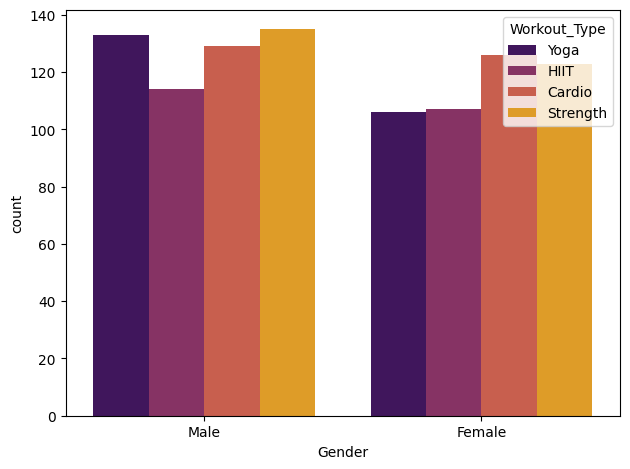

In [667]:
sns.countplot(x='Gender',hue='Workout_Type',data=gym_df,palette='inferno')
plt.tight_layout()
plt.show()

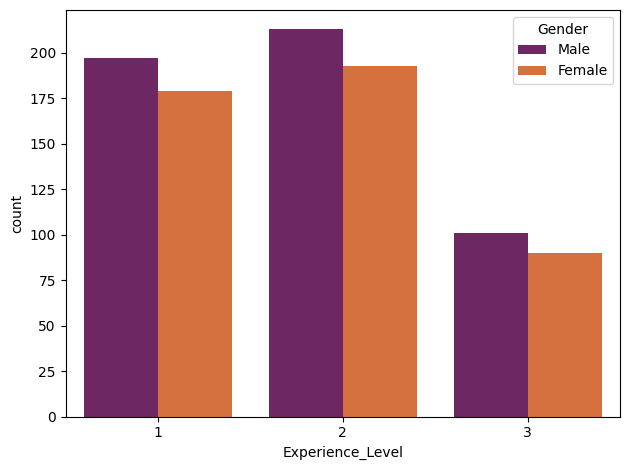

In [668]:
sns.countplot(x='Experience_Level',hue='Gender',data=gym_df,palette='inferno')
plt.tight_layout()
plt.show()

/var/folders/pm/1n104hls01s1wj_q43zb419m0000gn/T/ipykernel_7907/3731628646.py:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Workout_Type',y='Calories_Burned',data=gym_df,palette='inferno')


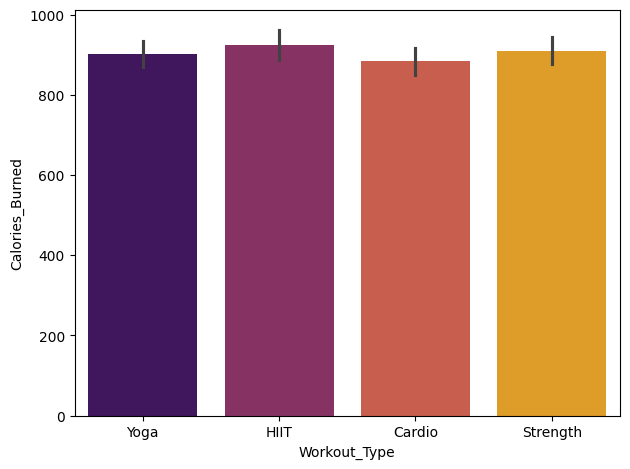

In [669]:
sns.barplot(x='Workout_Type',y='Calories_Burned',data=gym_df,palette='inferno')
plt.tight_layout()
plt.show()

## 3. Feature Engineering: Age Grouping

Age is grouped into categorical bins to improve interpretability and reduce sensitivity to small numerical differences.


In [670]:
bins = [18,25,35,45,55,100]
labels = ['18-25','26-35','36-45','46-55','56+']
gym_df['Age_label'] = pd.cut(gym_df['Age'],bins = bins, labels=labels, right = True,include_lowest=True)
print(gym_df.head())

   Age  Gender  Weight (kg)  Height (m)  Max_BPM  Avg_BPM  Resting_BPM  \
0   56    Male         88.3        1.71      180      157           60   
1   46  Female         74.9        1.53      179      151           66   
2   32  Female         68.1        1.66      167      122           54   
3   25    Male         53.2        1.70      190      164           56   
4   38    Male         46.1        1.79      188      158           68   

   Session_Duration (hours)  Calories_Burned Workout_Type  Fat_Percentage  \
0                      1.69           1313.0         Yoga            12.6   
1                      1.30            883.0         HIIT            33.9   
2                      1.11            677.0       Cardio            33.4   
3                      0.59            532.0     Strength            28.8   
4                      0.64            556.0     Strength            29.2   

   Water_Intake (liters)  Workout_Frequency (days/week)  Experience_Level  \
0              

## 4. Target Variable Definition

The original `Experience_Level` feature is converted into a binary target:
- Beginner: Experience_Level = 1
- Experienced: Experience_Level = 2 or 3


In [671]:
gym_df['Experience_binary'] = gym_df['Experience_Level'].apply(lambda x: 'Beginner' if x==1 else 'Experienced')

In [672]:
print(gym_df.head())

   Age  Gender  Weight (kg)  Height (m)  Max_BPM  Avg_BPM  Resting_BPM  \
0   56    Male         88.3        1.71      180      157           60   
1   46  Female         74.9        1.53      179      151           66   
2   32  Female         68.1        1.66      167      122           54   
3   25    Male         53.2        1.70      190      164           56   
4   38    Male         46.1        1.79      188      158           68   

   Session_Duration (hours)  Calories_Burned Workout_Type  Fat_Percentage  \
0                      1.69           1313.0         Yoga            12.6   
1                      1.30            883.0         HIIT            33.9   
2                      1.11            677.0       Cardio            33.4   
3                      0.59            532.0     Strength            28.8   
4                      0.64            556.0     Strength            29.2   

   Water_Intake (liters)  Workout_Frequency (days/week)  Experience_Level  \
0              

/var/folders/pm/1n104hls01s1wj_q43zb419m0000gn/T/ipykernel_7907/1772426955.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby(['Age_label', 'Experience_binary'])


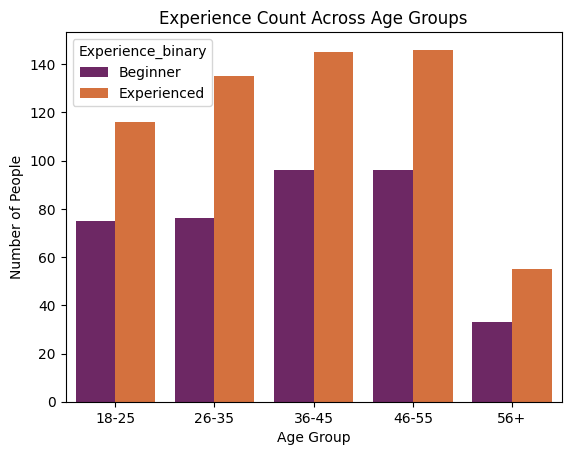

In [673]:
age_exp_counts = (
    gym_df
    .groupby(['Age_label', 'Experience_binary'])
    .size()
    .reset_index (name='Count')
)
sns.barplot(
    data = age_exp_counts,
    x = 'Age_label',
    y = 'Count',
    hue = 'Experience_binary',
    palette = 'inferno'
)
plt.xlabel('Age Group')
plt.ylabel('Number of People')
plt.title('Experience Count Across Age Groups')
plt.show()

## 5. Feature Selection

Features that may cause data leakage or are redundant are removed to ensure fair model training.


In [674]:
gym_df.drop(columns = ['Weight (kg)', 'Height (m)','Age','Experience_Level','Max_BPM','Calories_Burned','Workout_Type','Gender'],inplace=True)


In [675]:
print(gym_df.head().to_string())

   Avg_BPM  Resting_BPM  Session_Duration (hours)  Fat_Percentage  Water_Intake (liters)  Workout_Frequency (days/week)    BMI Age_label Experience_binary
0      157           60                      1.69            12.6                    3.5                              4  30.20       56+       Experienced
1      151           66                      1.30            33.9                    2.1                              4  32.00     46-55       Experienced
2      122           54                      1.11            33.4                    2.3                              4  24.71     26-35       Experienced
3      164           56                      0.59            28.8                    2.1                              3  18.41     18-25          Beginner
4      158           68                      0.64            29.2                    2.8                              3  14.39     36-45          Beginner


In [676]:
X = gym_df.drop(columns=['Experience_binary'])
y = gym_df['Experience_binary']

## 6. Train–Test Split

The dataset is split into training and test sets using a 75/25 ratio. The test set is held out for final evaluation.


In [677]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size = 0.25,random_state= 42)

In [678]:
print(X_train.shape,y_train.shape)
print(X_test.shape,y_test.shape)

(729, 8) (729,)
(244, 8) (244,)


## 7. Encoding and Scaling

Categorical features are encoded, and numerical features are standardized to ensure compatibility with distance-based models such as SVM.


In [679]:
le = LabelEncoder()
y_train = le.fit_transform(y_train)

In [680]:
y_test = le.transform(y_test)

In [681]:
le.classes_

array(['Beginner', 'Experienced'], dtype=object)

In [682]:
np.unique(y_train, return_counts=True)

(array([0, 1]), array([277, 452]))

In [683]:
np.unique(y_test, return_counts=True)

(array([0, 1]), array([ 99, 145]))

In [684]:
ohe = OneHotEncoder(sparse_output = False,drop = 'first')
age_oh_train = ohe.fit_transform (X_train[['Age_label']])
age_ohe_test = ohe.transform(X_test[['Age_label']])

In [685]:
age_ohe_cols = ohe.get_feature_names_out(['Age_label'])
age_train = pd.DataFrame(age_oh_train,columns = age_ohe_cols,index = X_train.index)
age_test = pd.DataFrame(age_ohe_test,columns = age_ohe_cols, index = X_test.index)
X_train = X_train.drop(columns = 'Age_label')
X_test = X_test.drop(columns = 'Age_label')
X_train = pd.concat([X_train,age_train],axis = 1)
X_test = pd.concat([X_test,age_test],axis=1)

In [686]:
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

## 8. Baseline Model: Logistic Regression

Logistic Regression is used as a baseline to assess linear separability in the data.


In [687]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix,classification_report,accuracy_score

In [688]:
print(X_train.shape,y_train.shape)
print(X_test.shape,y_test.shape)

(729, 11) (729,)
(244, 11) (244,)


In [689]:
lr = LogisticRegression(max_iter = 1000)
lr.fit(X_train,y_train)
y_pred = lr.predict(X_test)
print("Accuracy_score: ",accuracy_score(y_test,y_pred))
print("classification_report: \n",classification_report(y_test,y_pred))
print("confusion_matrix: \n",confusion_matrix(y_test,y_pred))

Accuracy_score:  0.8811475409836066
classification_report: 
               precision    recall  f1-score   support

           0       0.86      0.84      0.85        99
           1       0.89      0.91      0.90       145

    accuracy                           0.88       244
   macro avg       0.88      0.87      0.88       244
weighted avg       0.88      0.88      0.88       244

confusion_matrix: 
 [[ 83  16]
 [ 13 132]]


## 9. Support Vector Machines

Both linear and RBF kernel SVMs are trained to compare linear and nonlinear decision boundaries.


In [690]:
from sklearn.svm import SVC

In [691]:
svm = SVC(kernel ='linear',C=1)
svm.fit(X_train,y_train)
y_pred1 = svm.predict(X_test)
print("Accuracy_score: ",accuracy_score(y_test,y_pred1))
print("classification_report: \n",classification_report(y_test,y_pred1))
print("confusion_matrix: \n",confusion_matrix(y_test,y_pred1))

Accuracy_score:  0.8934426229508197
classification_report: 
               precision    recall  f1-score   support

           0       0.91      0.82      0.86        99
           1       0.88      0.94      0.91       145

    accuracy                           0.89       244
   macro avg       0.90      0.88      0.89       244
weighted avg       0.89      0.89      0.89       244

confusion_matrix: 
 [[ 81  18]
 [  8 137]]


In [692]:
svm = SVC(kernel ='rbf',C=1,gamma = 0.002)
svm.fit(X_train,y_train)
y_pred2 = svm.predict(X_test)
print("Accuracy_score: ",accuracy_score(y_test,y_pred2))
print("classification_report: \n",classification_report(y_test,y_pred2))
print("confusion_matrix: \n",confusion_matrix(y_test,y_pred2))

Accuracy_score:  0.8975409836065574
classification_report: 
               precision    recall  f1-score   support

           0       0.91      0.83      0.87        99
           1       0.89      0.94      0.92       145

    accuracy                           0.90       244
   macro avg       0.90      0.89      0.89       244
weighted avg       0.90      0.90      0.90       244

confusion_matrix: 
 [[ 82  17]
 [  8 137]]


## 10. Hyperparameter Tuning with Cross-Validation

GridSearchCV is used to tune SVM hyperparameters using 5-fold cross-validation to ensure robust model selection.


In [693]:
pipeline_gridSearch = Pipeline([
    ('scaler',sc),
    ('model',SVC(kernel ='rbf'))
])

In [694]:
param_grid = {
    'model__C':[0.1,1,2,10],
    'model__gamma':[0.001,0.002,0.1,1]
}

In [695]:
grid = GridSearchCV(
    pipeline_gridSearch,
    param_grid,
    scoring = 'accuracy',
    cv = 5,
    n_jobs=-1
)

In [696]:
grid.fit(X_train,y_train)

,"estimator estimator: estimator objectThis is assumed to implement the scikit-learn estimator interface.Either estimator needs to provide a ``score`` function,or ``scoring`` must be passed.","Pipeline(step...del', SVC())])"
,"param_grid param_grid: dict or list of dictionariesDictionary with parameters names (`str`) as keys and lists ofparameter settings to try as values, or a list of suchdictionaries, in which case the grids spanned by each dictionaryin the list are explored. This enables searching over any sequenceof parameter settings.","{'model__C': [0.1, 1, ...], 'model__gamma': [0.001, 0.002, ...]}"
,"scoring scoring: str, callable, list, tuple or dict, default=NoneStrategy to evaluate the performance of the cross-validated model onthe test set.If `scoring` represents a single score, one can use:- a single string (see :ref:`scoring_string_names`);- a callable (see :ref:`scoring_callable`) that returns a single value;- `None`, the `estimator`'s :ref:`default evaluation criterion ` is used.If `scoring` represents multiple scores, one can use:- a list or tuple of unique strings;- a callable returning a dictionary where the keys are the metric names and the values are the metric scores;- a dictionary with metric names as keys and callables as values.See :ref:`multimetric_grid_search` for an example.",'accuracy'
,"n_jobs n_jobs: int, default=NoneNumber of jobs to run in parallel.``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.``-1`` means using all processors. See :term:`Glossary `for more details... versionchanged:: v0.20 `n_jobs` default changed from 1 to None",-1
,"refit refit: bool, str, or callable, default=TrueRefit an estimator using the best found parameters on the wholedataset.For multiple metric evaluation, this needs to be a `str` denoting thescorer that would be used to find the best parameters for refittingthe estimator at the end.Where there are considerations other than maximum score inchoosing a best estimator, ``refit`` can be set to a function whichreturns the selected ``best_index_`` given ``cv_results_``. In thatcase, the ``best_estimator_`` and ``best_params_`` will be setaccording to the returned ``best_index_`` while the ``best_score_``attribute will not be available.The refitted estimator is made available at the ``best_estimator_``attribute and permits using ``predict`` directly on this``GridSearchCV`` instance.Also for multiple metric evaluation, the attributes ``best_index_``,``best_score_`` and ``best_params_`` will only be available if``refit`` is set and all of them will be determined w.r.t this specificscorer.See ``scoring`` parameter to know more about multiple metricevaluation.See :ref:`sphx_glr_auto_examples_model_selection_plot_grid_search_digits.py`to see how to design a custom selection strategy using a callablevia `refit`.See :ref:`this example`for an example of how to use ``refit=callable`` to balance modelcomplexity and cross-validated score... versionchanged:: 0.20 Support for callable added.",True
,"cv cv: int, cross-validation generator or an iterable, default=NoneDetermines the cross-validation splitting strategy.Possible inputs for cv are:- None, to use the default 5-fold cross validation,- integer, to specify the number of folds in a `(Stratified)KFold`,- :term:`CV splitter`,- An iterable yielding (train, test) splits as arrays of indices.For integer/None inputs, if the estimator is a classifier and ``y`` iseither binary or multiclass, :class:`StratifiedKFold` is used. In allother cases, :class:`KFold` is used. These splitters are instantiatedwith `shuffle=False` so the splits will be the same across calls.Refer :ref:`User Guide ` for the variouscross-validation strategies that can be used here... versionchanged:: 0.22 ``cv`` default value if None changed from 3-fold to 5-fold.",5
,"verbose verbose: intControls the verbosity: the higher, the more messages.- >1 : the computation time for each fold and parameter candidate is displayed;- >2 : the score is also di

In [697]:
print(grid.best_params_)

{'model__C': 2, 'model__gamma': 0.001}


In [698]:
y_pred = grid.predict(X_test)

In [699]:
print(grid.best_score_)

0.8902314596126594


In [700]:
high_model = grid.best_estimator_

In [701]:
y_pred_Svm = high_model.predict(X_test)

## 11. Final Model Evaluation

The best-performing model from cross-validation is evaluated on the test set using accuracy, precision, recall, and confusion matrix.


In [702]:
print(confusion_matrix(y_test, y_pred_Svm))
print(classification_report(y_test, y_pred_Svm))

[[ 82  17]
 [  9 136]]
              precision    recall  f1-score   support

           0       0.90      0.83      0.86        99
           1       0.89      0.94      0.91       145

    accuracy                           0.89       244
   macro avg       0.89      0.88      0.89       244
weighted avg       0.89      0.89      0.89       244

